# Analyse the results

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

Create one big result file for stage 2 processing.

In [2]:
def concat_result(resultDir):
    df_result = pd.DataFrame()
    i = 0
    for file in os.listdir(resultDir):
        if 'R' in file:
            directory = file
            for file2 in os.listdir(resultDir + directory + '/'):
                if 'result_OCRpass' in file2:
                    fn_parts = file2.split('_')
                    subdirectory = fn_parts[2].replace('.csv', '')
                    if i > 0:
                        if i % 100 == 0:
                            df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                            print(len(df_result))
                    try:
                        df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                        n = len(df_load)
                    except pd.errors.EmptyDataError:
                        n = 0
                    df_result = pd.concat([df_result, df_load])
                    i += 1
                    if i % 100 == 0:
                        print('Now saving the ' + str(i) + 'th result...')
                        df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
    
    return(df_result)

In [3]:
resultDir = 'L:/DATA/ISIS/ISIS_test_Run/05_result/'
#df_result = concat_result(resultDir)
#df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

In [4]:
df_total = pd.read_csv(resultDir + 'result_stage2_raw.csv',
                          usecols=['Directory','Subdirectory','filename','string_read_OCR'])

In [5]:
df_total.head()

,Directory,Subdirectory,filename,string_read_OCR
0,R014207767,B1-35-26 ISIS B D-769,Image0195.png,"(72, 5, 10, , 1, 1)"
1,R014207767,B1-35-26 ISIS B D-769,Image0196.png,"(0, 51, 5, 3, 5, )"
2,R014207767,B1-35-26 ISIS B D-769,Image0197.png,"(00, , 11)"
3,R014207767,B1-35-26 ISIS B D-769,Image0297.png,"(, 1, 1)"
4,R014207767,B1-35-26 ISIS B D-769,Image0311.png,"(069, 12, 124)"


In [6]:
def create_sample(df_total):
    df_to_analyse = df_total.sample(100)
    df_to_analyse.reset_index(drop=True,inplace=True)
    df_to_analyse['string_length_OCR']=''
    for i in range(len(df_to_analyse)):
        df_to_analyse.at[i,'string_length_OCR'] = sum(str(n).isdigit() for n in str(df_to_analyse['string_read_OCR'][i]))
    df_to_analyse['length_15'] = np.where(df_to_analyse['string_length_OCR']==15,True,False)
    return(df_to_analyse)

In [7]:
df_to_analyse = create_sample(df_total)

In [8]:
df_to_analyse.head()

,Directory,Subdirectory,filename,string_read_OCR,string_length_OCR,length_15
0,R014207779,B1-35-25 ISIS B D-717,Image0199.png,"(095728, 13, 013, 1, 50, 0)",15,True
1,R014207852,B1-35-16 ISIS B D-174,Image0010.png,"(241, 032, 4, 3, 2)",9,False
2,R014207779,B1-35-25 ISIS B D-751,Image0537.png,"(, 54, 11)",4,False
3,R014207869,B1-34-49 ISIS-A C-247-03,Image0112.png,"(154, 65, 13, 11)",9,False
4,R014207767,B1-35-26 ISIS B D-817,Image0421.png,"(6972, 016, 0113, 42)",13,False


In [9]:
#df_to_analyse.to_csv('L:/DATA/ISIS/keras_ocr_training/sample_to_analyse.csv', index=False)

Manually, I will look at the images and the string read by keras OCR to give us an idea for the accuracy. Three columns will be added : left_to_right_order, accurate_numbers, perfect. 
**The column perfect means there are 15 digits and they are the correct ones, but they might not be in the right order in the string.**
Now, I'll upload the file I used for my tests to create some plots.

In [10]:
df_to_plot = pd.read_csv('L:/DATA/ISIS/keras_ocr_training/sample_to_analyse_v1.csv')
df_to_plot.head()

,Directory,Subdirectory,filename,string_read_OCR,string_length_OCR,length_15,left_to_right_order,accurate_numbers,perfect
0,R014207767,B1-35-26 ISIS B D-772,Image0264.png,"(1972, 115, 315)",10,False,True,7.0,False
1,R014207852,B1-35-16 ISIS B D-172,Image0195.png,"(00, 0256, 0, 3)",8,False,False,7.0,False
2,R014207852,B1-35-16 ISIS B D-175,Image0475.png,"(71, 50, 303, 1634, 15, 4)",14,False,False,13.0,False
3,R014207852,B1-35-16 ISIS B D-176,Image0264.png,"(50, 305, 1943, 4, 11)",12,False,False,10.0,False
4,R014207848,B1-35-7 ISIS A C-1529,Image0442.png,"(20, 3, 1)",4,False,False,2.0,False


Let's start with the average string length read by keras_OCR. I will plot this metric per subdirectory and total.

In [11]:
import matplotlib.pyplot as plt

df_length = df_to_plot.groupby('Directory')['string_length_OCR'].mean()
df_length = df_length.reset_index()

In [12]:
length_mean = df_to_plot['string_length_OCR'].mean()

In [13]:
df_length.loc[len(df_length)] = ['Total', length_mean]
df_length

,Directory,string_length_OCR
0,R014207767,12.105263
1,R014207779,10.400000
2,R014207848,9.250000
3,R014207852,10.900000
4,R014207869,4.625000
5,R014207872,10.266667
6,Total,9.684783


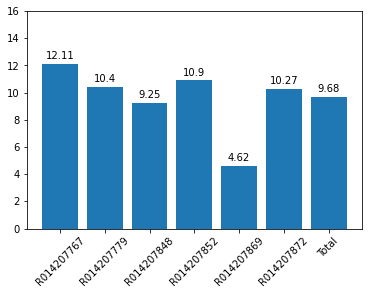

In [14]:
fig, ax = plt.subplots()
length_plot = ax.bar(df_length['Directory'],df_length['string_length_OCR'])
ax.tick_params(axis='x',rotation=45)
ax.set_ylim((0,16))
for bar in length_plot:
    height = round(bar.get_height(),2)
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

Keras_ocr detector is having trouble identifying the presence of text, which explains the numbers above. For the directory R014207869, there's a line on top of the numbers, so it is even harder.

In [15]:
df_order = df_to_plot['left_to_right_order'].value_counts()
df_order = df_order.reset_index()
df_order.columns = ['label','left_to_right_order']
df_order

,label,left_to_right_order
0,False,85
1,True,6


[Text(0, 0, 'False'), Text(1, 0, 'True')]

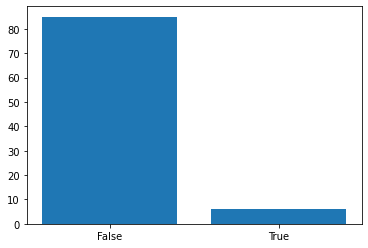

In [16]:
fig, ax = plt.subplots()
ax.bar(df_order['label'],df_order['left_to_right_order'])
ax.set_xticks(ticks = [0,1])
ax.set_xticklabels(['False','True'])

The cases where the numbers are read in the right order are pretty rare. We would definitly need to adjust before doing more processing.

In [17]:
df_to_plot.loc[df_to_plot['perfect']==True]

,Directory,Subdirectory,filename,string_read_OCR,string_length_OCR,length_15,left_to_right_order,accurate_numbers,perfect
19,R014207767,B1-35-26 ISIS B D-793,Image0623.png,"(69, 72, 0427, 34, 44, 030)",15,True,False,15.0,True
87,R014207767,B1-35-26 ISIS B D-826,Image0032.png,"(6972, 18, 0812, 42, 153)",15,True,False,15.0,True


Out of the sample, those are the only subdirectories that were "perfect". Keras_OCR read 15 digits and they were the right ones.

In [18]:
df_accuracy = df_to_plot.loc[df_to_plot['string_length_OCR']!=0]

In [19]:
df_accuracy = df_accuracy.groupby(by='Directory')[['string_length_OCR','accurate_numbers']].sum()
df_accuracy = df_accuracy.reset_index()
df_accuracy.columns = ['Directory','left_to_right_order','accurate_numbers']

In [20]:
sum1 =  df_to_plot['string_length_OCR'].sum()
sum2 = df_to_plot['accurate_numbers'].sum()
df_accuracy.loc[len(df_accuracy)] = ['Total', sum1, sum2]

In [21]:
df_accuracy['ratio'] = (df_accuracy['accurate_numbers'] / df_accuracy['left_to_right_order'])*100

In [22]:
df_accuracy

,Directory,left_to_right_order,accurate_numbers,ratio
0,R014207767,230,177.0,76.956522
1,R014207779,104,91.0,87.500000
2,R014207848,111,97.0,87.387387
3,R014207852,218,160.0,73.394495
4,R014207869,74,40.0,54.054054
5,R014207872,154,97.0,62.987013
6,Total,891,662.0,74.298541


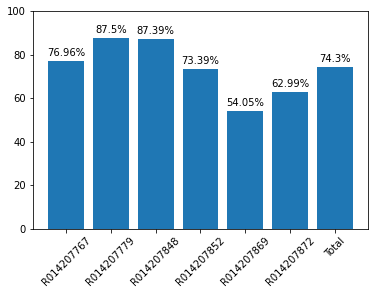

In [23]:
fig, ax = plt.subplots()
accuracy_plot = ax.bar(df_accuracy['Directory'],df_accuracy['ratio'])
ax.tick_params(axis='x',rotation=45)
ax.set_ylim((0,100))
for bar in accuracy_plot:
    height = round(bar.get_height(),2)
    ax.annotate('{}'.format(height)+'%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')